# **트레이딩 전략과 구현 6장 포트폴리오 이론**
**[파이썬 증권 데이터 분석 6장](https://nbviewer.jupyter.org/github/INVESTAR/StockAnalysisInPython/tree/master/06_Trading_Strategy/)**
 | **[nbviewer](https://github.com/INVESTAR/StockAnalysisInPython/blob/master/06_Trading_Strategy/ch06_01_EfficientFrontier.py)** | **[Markdown Wiki](https://ko.wikipedia.org/wiki/%EC%9C%84%ED%82%A4%EB%B0%B1%EA%B3%BC:TeX_%EB%AC%B8%EB%B2%95)** | **[Markdown Editor](http://www.hostmath.com/)**


# **1 효율적 투자선**
## **01 데이터 불러오기 및 확인**
- 삼성, 현대차, Naver, HMM 효율투자선 분석
- **[FinanceDataReader](https://github.com/FinanceData/FinanceDataReader)** | **[yfinance](https://github.com/ranaroussi/yfinance)**

In [1]:
# 효율적 투자선 분석기업 Codes
code_dict = {"005930":"삼성전자", "005380":"현대차", "011200":"HMM", "035420":"NAVER"}

import os
import pandas as pd
file_save = "data/EfficientFrontier.csv"
if os.path.isfile(file_save):
    data_df = pd.read_csv(file_save)
    data_df['Date'] = pd.to_datetime(data_df['Date']) # datetime 포맷 변경
    data_df = data_df.set_index('Date')
else:
    import FinanceDataReader as fdr
    data_df = [fdr.DataReader(_, start="2019-1-1")['Close'] for _ in code_dict.keys()]
    data_df = pd.concat(data_df, axis=1)
    data_df.columns = list(code_dict.values())
    data_df.to_csv(file_save)
data_df.tail(3)

삼성전자     현대차    HMM   NAVER
Date                                    
2021-07-30  78500  218000  40000  433500
2021-08-02  79300  220000  38650  433500
2021-08-03  81400  223500  37600  428000

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Loading ... Visualization Modules
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib.font_manager import fontManager as fm # 한글폰트 확인 및 추가
font_list_check  = ['D2Coding', 'NanumGothicCoding', 'NanumGothic']
for _ in font_list_check:
    font_counts = [f  for f in font_list_check if _ in [_.name for _ in fm.ttflist]]
    if len(font_counts) > 1: print(f"found : {_}"); plt.rc('font', family=_); break 

found : D2Coding


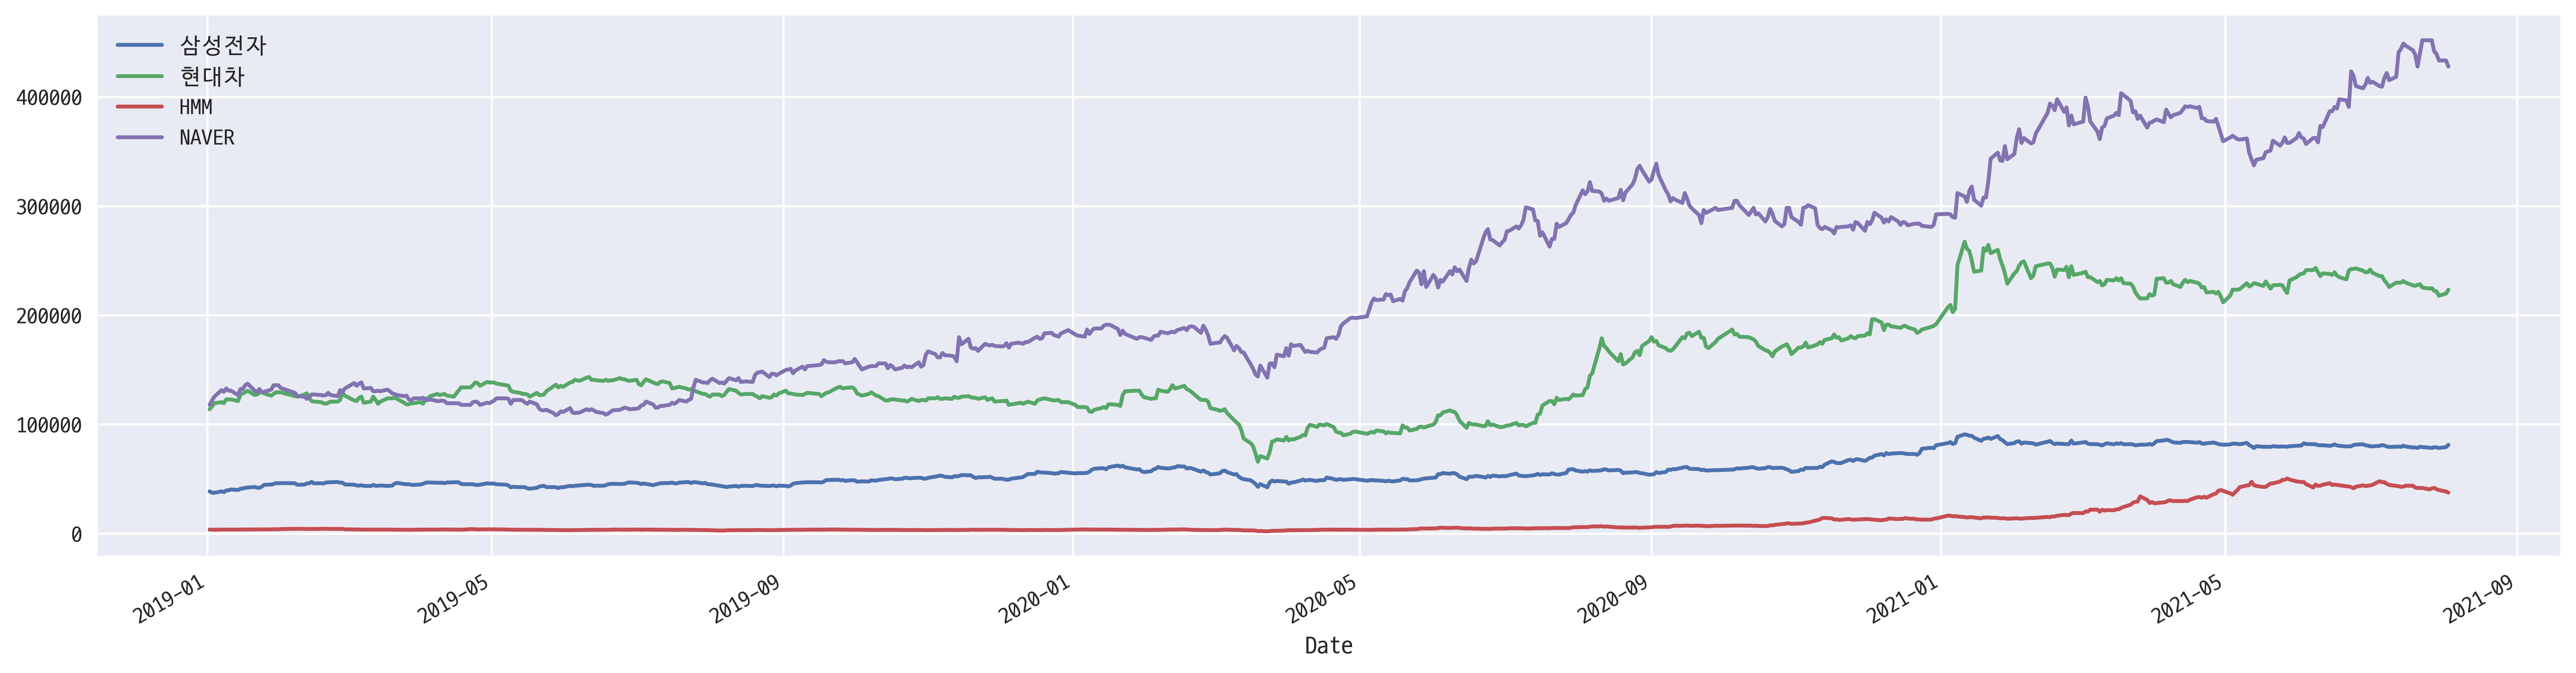

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (20.0, 5.0)
data_df.plot()
plt.show()

## **02 파생데이터 생성하기**
연간/ 일간 수익률, 연간/ 일간 리스크

In [4]:
# 일간 수익률
daily_rate = data_df.pct_change()
daily_rate.head(3)

삼성전자       현대차       HMM     NAVER
Date                                              
2019-01-02       NaN       NaN       NaN       NaN
2019-01-03 -0.029677  0.021930 -0.021333  0.033898
2019-01-04 -0.003989  0.025751 -0.009537  0.028689

In [5]:
# 연간 수익률
annual_rate = daily_rate.mean() * 252   
annual_rate

삼성전자     0.329309
현대차      0.341888
HMM      1.050902
NAVER    0.572314
dtype: float64

In [6]:
# 일간 리스크 : 변동률의 공분산
daily_cov = daily_rate.cov()
daily_cov

삼성전자       현대차       HMM     NAVER
삼성전자   0.000295  0.000215  0.000138  0.000120
현대차    0.000215  0.000624  0.000232  0.000147
HMM    0.000138  0.000232  0.001141  0.000096
NAVER  0.000120  0.000147  0.000096  0.000519

In [7]:
# 연간 리스크 : 일간 공분산 * 252
annual_cov = daily_cov * 252
annual_cov

삼성전자       현대차       HMM     NAVER
삼성전자   0.074318  0.054284  0.034847  0.030142
현대차    0.054284  0.157349  0.058460  0.036946
HMM    0.034847  0.058460  0.287443  0.024169
NAVER  0.030142  0.036946  0.024169  0.130832

## **03 몬테카를로 시뮬레이션**
- 포트폴리오 20,000 개 생성한 뒤 분석한 최적의 포트폴리오 비율 계산
- $포트폴리오 Risk = \sqrt{(종목별 비중)T((종목별 연간공분산) (종목별 비중))} $

In [8]:
%%time
stocks = list(code_dict.values())
port_rate, port_risk, port_weights = [], [], [] 

# 몬테카를로 시뮬레이션
import numpy as np
for _ in range(20000): 
    weights = np.random.random(len(stocks)) 
    weights /= np.sum(weights) 

    returns = np.dot(weights, annual_rate) 
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 

    port_rate.append(returns) 
    port_risk.append(risk) 
    port_weights.append(weights) 

CPU times: user 877 ms, sys: 11.3 ms, total: 888 ms
Wall time: 886 ms


In [9]:
# 포트폴리오의 수익률과 위험률 테이블로 정리
portfolio = {'Returns': port_rate, 'Risk': port_risk} 

# 기업별 비율을 적용하여 테이블 추가하기
for _, s in enumerate(stocks):
    portfolio[s] = [weight[_] for weight in port_weights]

portfolio_df = pd.DataFrame(portfolio) 
portfolio_df.tail(3)

Returns      Risk      삼성전자       현대차       HMM     NAVER
19997  0.533505  0.246261  0.445618  0.010221  0.150095  0.394066
19998  0.491280  0.254969  0.511918  0.201558  0.187654  0.098869
19999  0.576376  0.259771  0.381344  0.139026  0.269055  0.210575

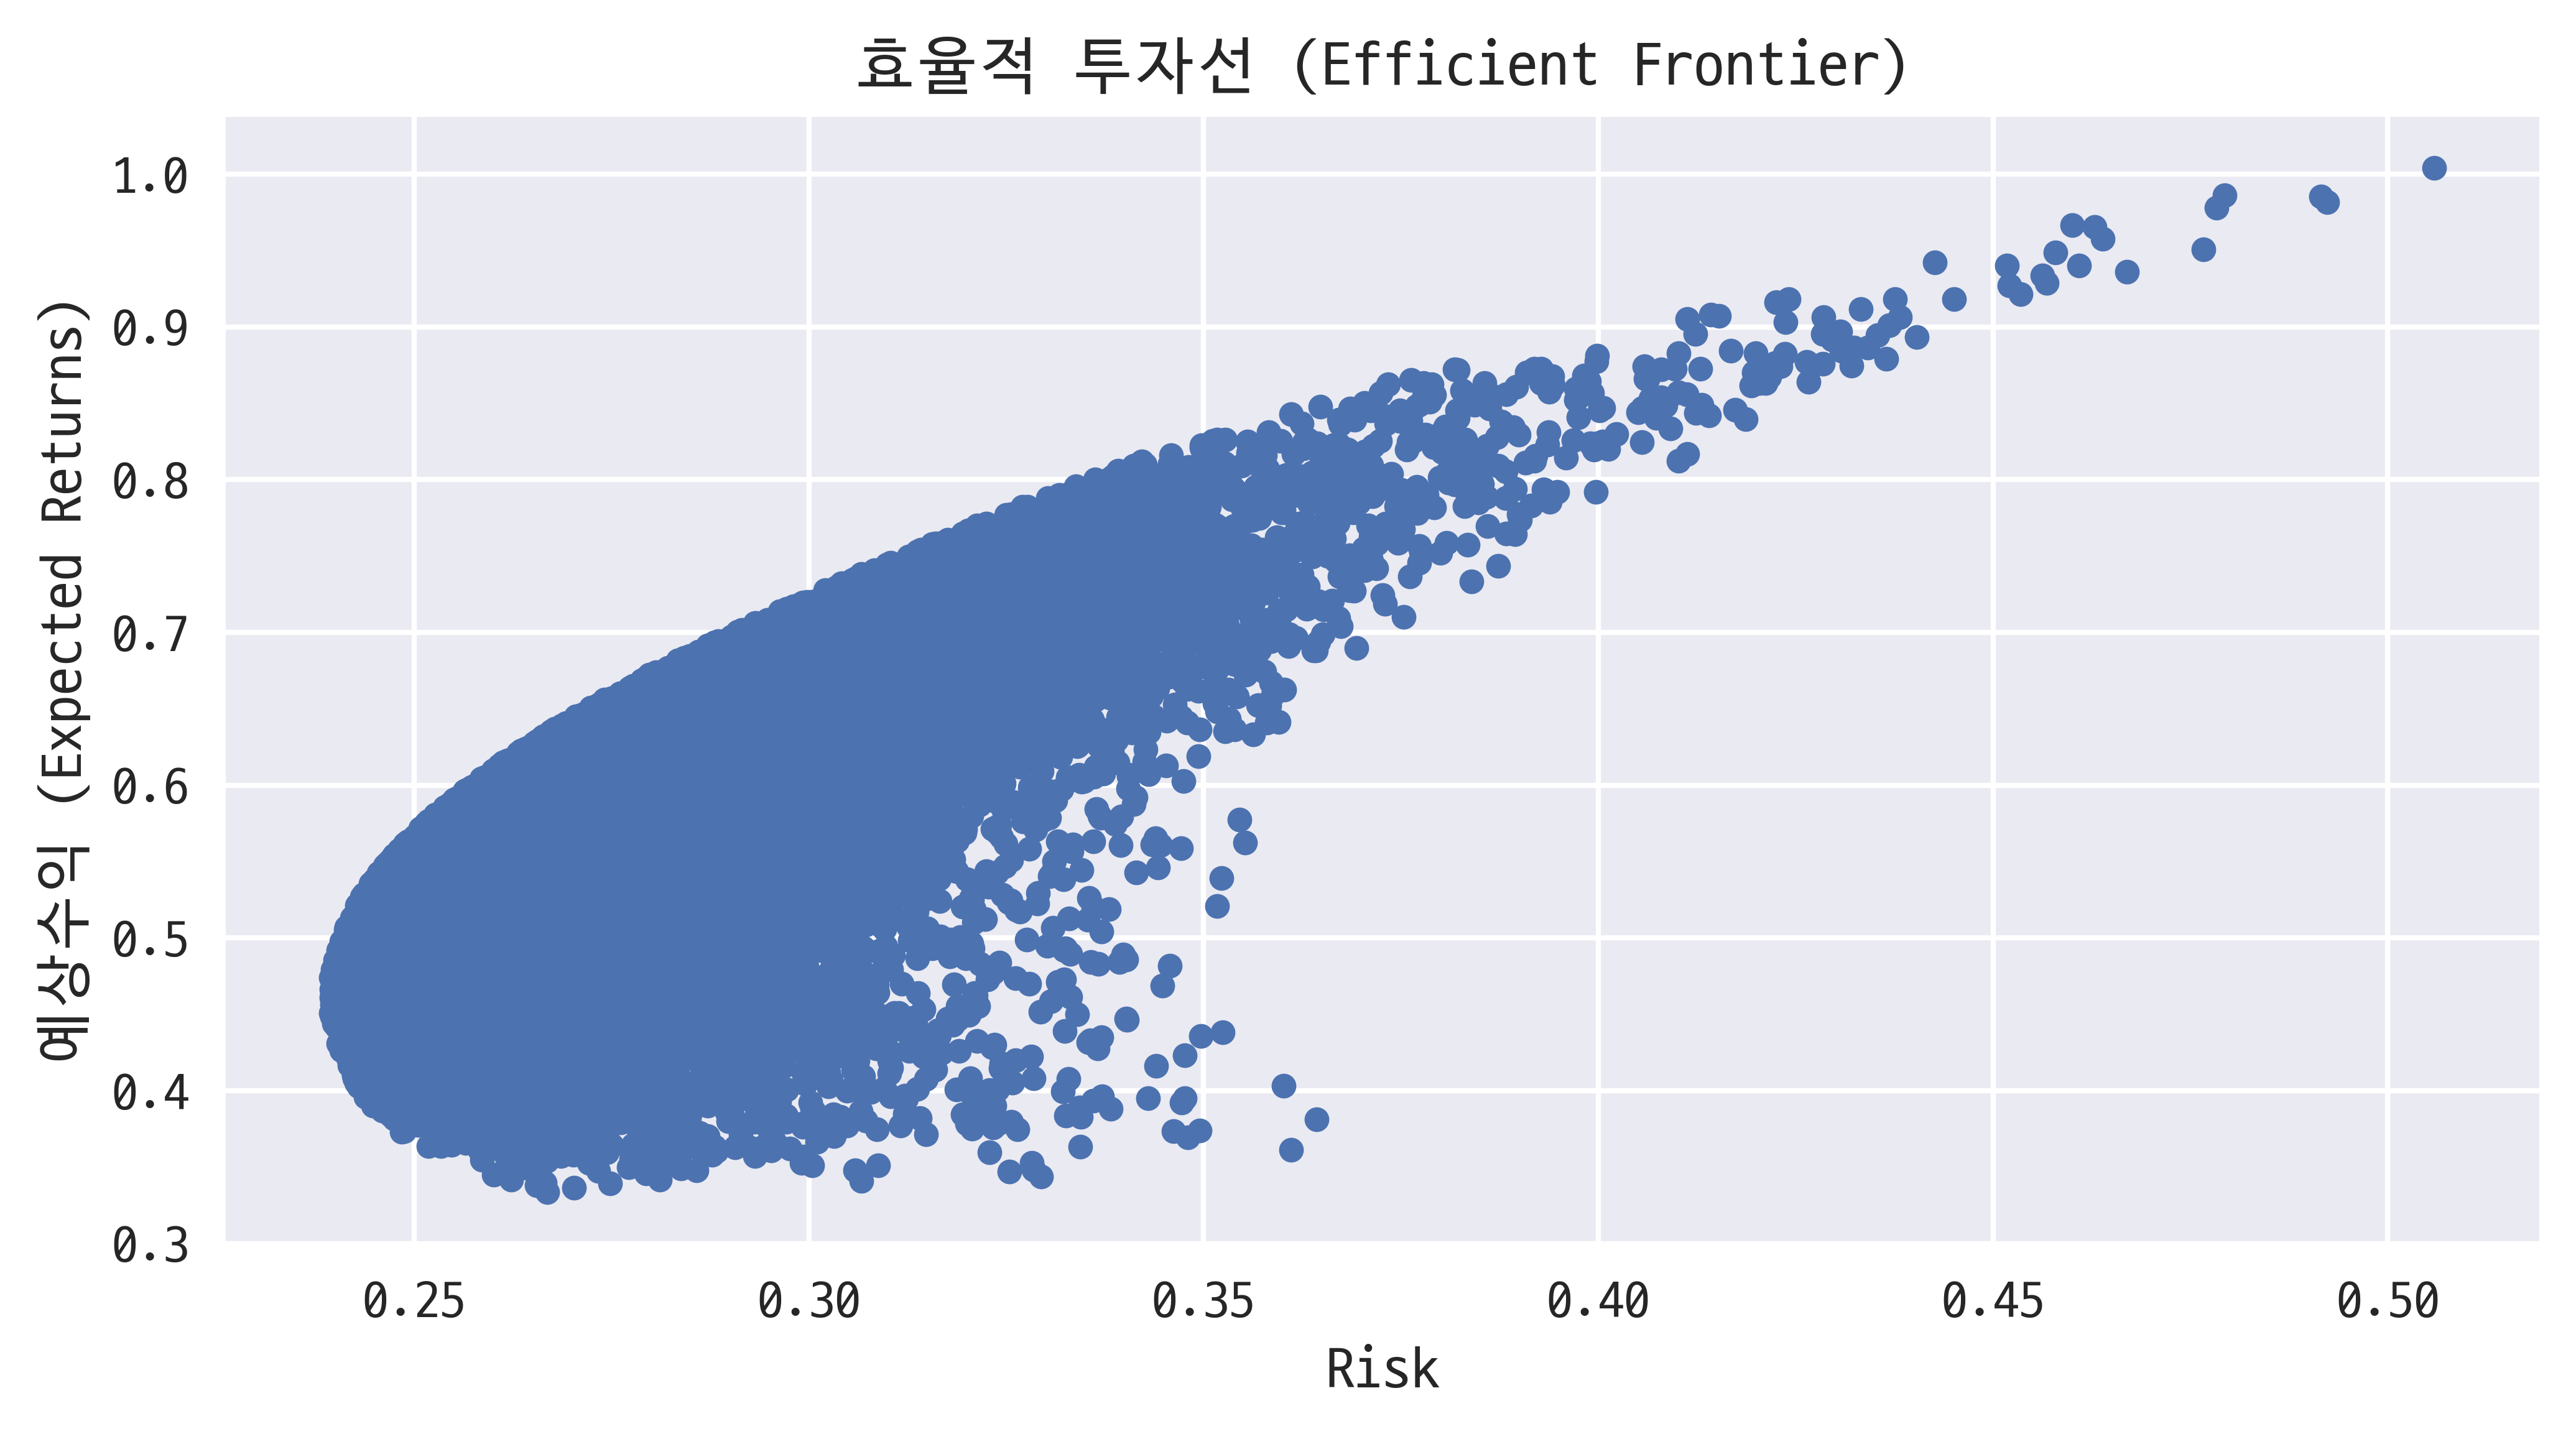

In [10]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = (20.0, 5.0)
portfolio_df.plot.scatter(x='Risk', y='Returns', figsize=(8, 4), grid=True)
plt.title('효율적 투자선 (Efficient Frontier)') 
plt.xlabel('Risk') 
plt.ylabel('예상수익 (Expected Returns)') 
plt.show() 

# **2 샤프 지수와 포트폴리오 최적화**
## **01 샤프지수**
- 측정된 위험 단위당 수익률의 계산 및 비교
- $ 사프지수 = {(포트폴리오 예상 수익률 - 무위험률) \over 수익률 표준편차} $

In [11]:
%%time
# Sharp 지수를 추가하여 시뮬레이션 실행
stocks = list(code_dict.values())
port_rate, port_risk, port_weights, sharpe_ratio = [], [], [], [] 

for _ in range(20000): 
    weights = np.random.random(len(stocks)) 
    weights /= np.sum(weights) 

    returns = np.dot(weights, annual_rate) 
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 

    port_rate.append(returns) 
    port_risk.append(risk) 
    port_weights.append(weights)
    sharpe_ratio.append(returns/risk)

CPU times: user 827 ms, sys: 8.4 ms, total: 836 ms
Wall time: 830 ms


In [12]:
# table 로 내용의 정리
portfolio = {'Returns': port_rate, 'Risk': port_risk, 'Sharpe': sharpe_ratio}

for _, s in enumerate(stocks): 
    portfolio[s] = [weight[_] for weight in port_weights] 
portfolio_df = pd.DataFrame(portfolio)
portfolio_df.tail(3)

Returns      Risk    Sharpe      삼성전자       현대차       HMM     NAVER
19997  0.539369  0.247663  2.177829  0.410043  0.027780  0.152739  0.409438
19998  0.346559  0.289031  1.199035  0.459831  0.504575  0.004709  0.030885
19999  0.538927  0.270150  1.994919  0.259124  0.335928  0.223550  0.181398

In [13]:
# 최대 리스크 포트폴리오 찾기
max_sharpe = portfolio_df.loc[portfolio_df['Sharpe'] == portfolio_df['Sharpe'].max()]
max_sharpe

Returns      Risk    Sharpe      삼성전자       현대차       HMM     NAVER
19232  0.708654  0.293913  2.411102  0.193955  0.001151  0.383915  0.420979

In [14]:
# 최소 리스크 포트폴리오 찾기
min_risk   = portfolio_df.loc[portfolio_df['Risk'] == portfolio_df['Risk'].min()]
min_risk 

Returns      Risk   Sharpe      삼성전자       현대차      HMM     NAVER
12456  0.456997  0.239397  1.90895  0.566983  0.073201  0.08218  0.277636

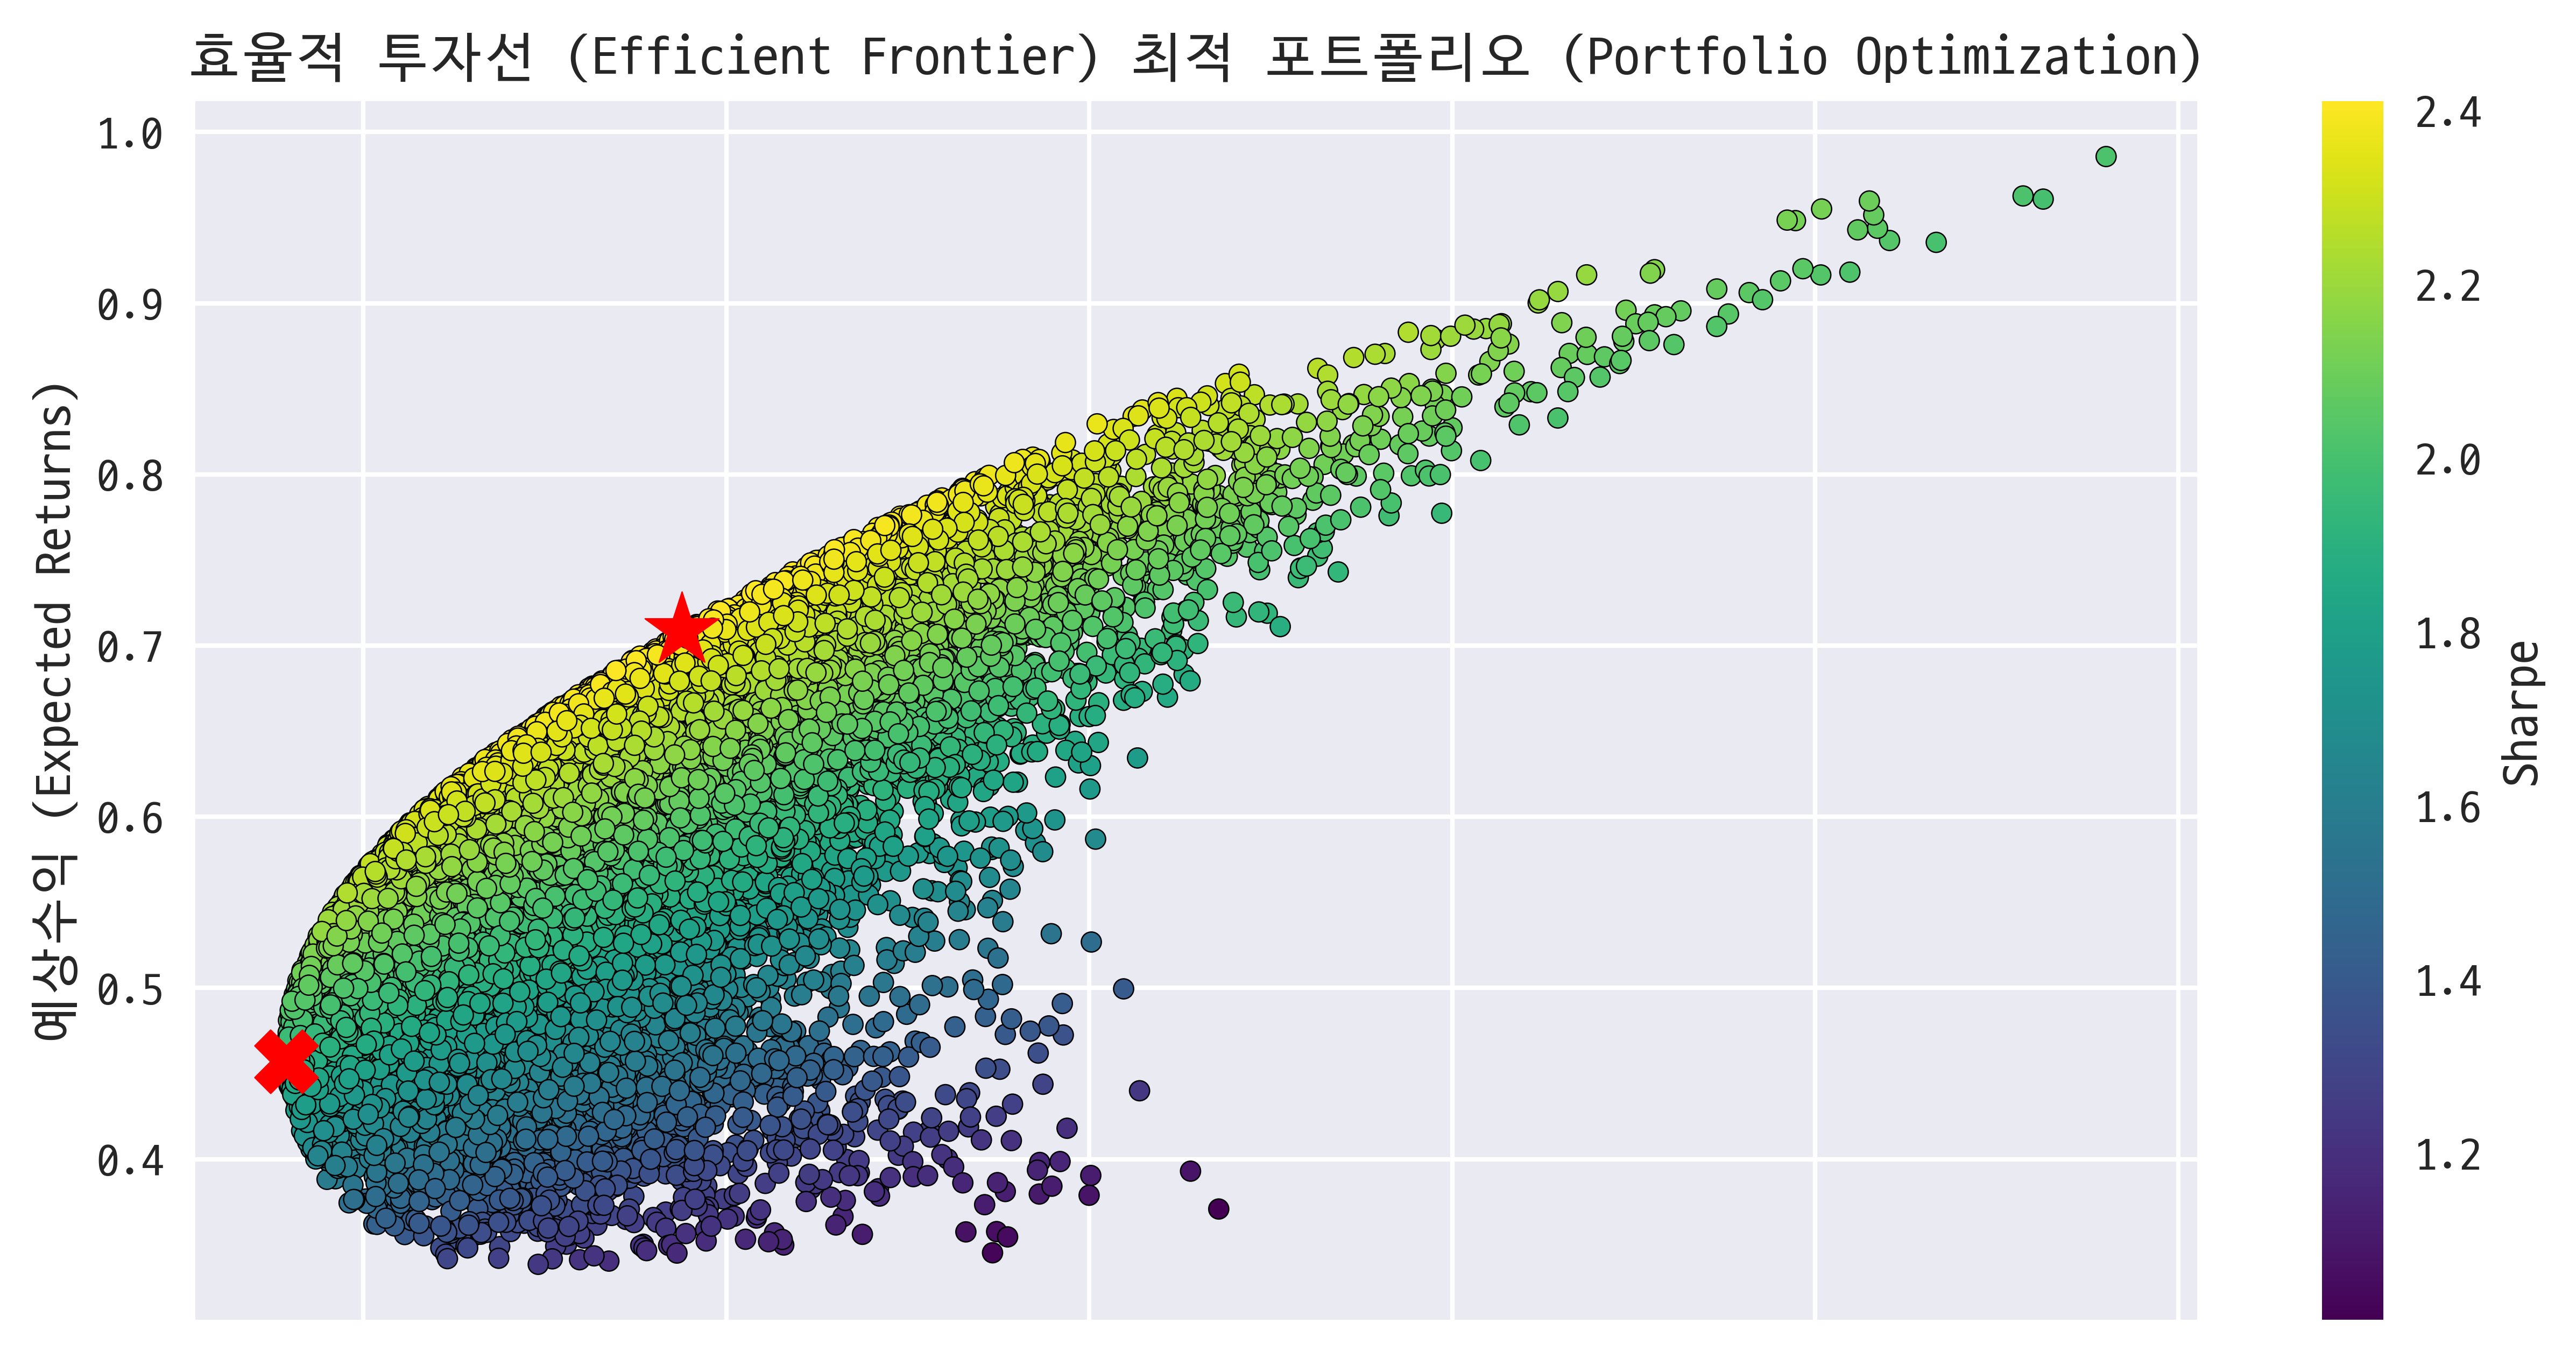

In [15]:
# 결과 시각화 출력하기
portfolio_df.plot.scatter(x='Risk', y='Returns', c='Sharpe', 
            cmap='viridis', edgecolors='k', figsize=(10,5), grid=True)

plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], 
            c='r', marker='*', s=300) # 최대 위험 / 수익구간
plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], 
            c='r', marker='X', s=200) # 최소 위험 / 수익구각
plt.title('효율적 투자선 (Efficient Frontier) 최적 포트폴리오 (Portfolio Optimization)') 
plt.xlabel('Risk') 
plt.ylabel('예상수익 (Expected Returns)') 
plt.show()